# Принятие решений в бизнесе на основе данных. Приоритезация гипотез. A/B тест.
## Описание проекта
Вы — аналитик крупного интернет-магазина. Вместе с отделом маркетинга вы подготовили список гипотез для увеличения выручки.
Приоритизируйте гипотезы, запустите A/B-тест и проанализируйте результаты.


## Оглавление <a id='Оглавление'></a>

### Подготовка
1. [Загрузка датасетов и их проверка на наличие пропусков и на правильность выгрузки](#1)

### Приоритизация гипотез
2. [Примените фреймворк ICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.](#2)
3. [Примените фреймворк RICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.](#3)
4. [Укажите, как изменилась приоритизация гипотез при применении RICE вместо ICE. Объясните, почему так произошло.](#4)

### Анализ A/B-теста

**Кумулятивные метрики**

5. [Постройте график кумулятивной выручки по группам. Сделайте выводы и предположения.](#5)
6. [Постройте график кумулятивного среднего чека по группам. Сделайте выводы и предположения.](#6)
7. [Постройте график относительного изменения кумулятивного среднего чека группы B к группе A. Сделайте выводы и предположения.](#7)
10. [Постройте график кумулятивной конверсии по группам. Сделайте выводы и предположения.](#8)
11. [Постройте график относительного изменения кумулятивной конверсии группы B к группе A. Сделайте выводы и предположения.](#9)

**Анализ выбросов и всплесков**

12. [Постройте точечный график количества заказов по пользователям. Сделайте выводы и предположения.](#12)
13. [Посчитайте 95-й и 99-й перцентили количества заказов на пользователя. Выберите границу для определения аномальных пользователей.](#13)
14. [Постройте точечный график стоимостей заказов. Сделайте выводы и предположения.](#14)
15. [Посчитайте 95-й и 99-й перцентили стоимости заказов. Выберите границу для определения аномальных заказов.](#15)
16. [Посчитайте статистическую значимость различий в конверсии между группами по «сырым» данным. Сделайте выводы и предположения.](#16)
17. [Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Сделайте выводы и предположения.](#17)
18. [Посчитайте статистическую значимость различий в конверсии между группами по «очищенным» данным. Сделайте выводы и предположения.](#18)
19. [Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделайте выводы и предположения.](#19)

**Принятие решения по результатам теста**

20. [Примите решение по результатам теста и объясните его. Варианты решений: 1. Остановить тест, зафиксировать победу одной из групп. 2. Остановить тест, зафиксировать отсутствие различий между группами. 3. Продолжить тест.](#20)

<a id='1'></a>
# Шаг 1. Загрузите данные и подготовьте их к анализу
[*Назад к оглавлению*](#Оглавление)

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import math
from scipy import stats

from datetime import timedelta
import datetime as dt

from statsmodels.stats.proportion import proportions_ztest
import warnings

warnings.filterwarnings('ignore')

In [2]:
try:
    visitors = pd.read_csv('visitors.csv')
    orders = pd.read_csv('orders.csv')
    hypothesis = pd.read_csv('hypothesis.csv')
except:
    visitors, orders, hypothesis = (
    pd.read_csv('/datasets/visitors.csv'),  # журнал визитов
    pd.read_csv('/datasets/orders.csv'),  # заказы
    pd.read_csv('/datasets/hypothesis.csv')  # расходы
)

In [3]:
visitors.sample(5)

,date,group,visitors
17,2019-08-18,A,668
52,2019-08-22,B,650
5,2019-08-06,A,667
49,2019-08-19,B,487
27,2019-08-28,A,594


In [4]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [5]:
round((visitors.isna().mean()*100),2)

date        0.0
group       0.0
visitors    0.0
dtype: float64

In [6]:
visitors['date'] = pd.to_datetime(visitors['date'])

In [7]:
visitors.duplicated().sum()

0

In [8]:
orders.sample(5)

,transactionId,visitorId,date,revenue,group
777,3784111282,329473477,2019-08-27,12490,A
479,1651227034,2927087541,2019-08-24,2190,B
522,815003794,1303698307,2019-08-26,3390,B
945,1364984427,2010516786,2019-08-21,15485,B
469,3435237349,3342201840,2019-08-03,8990,B


In [9]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [10]:
round((orders.isna().mean()*100),2)

transactionId    0.0
visitorId        0.0
date             0.0
revenue          0.0
group            0.0
dtype: float64

In [11]:
orders['date'] = pd.to_datetime(orders['date'])

In [12]:
orders.duplicated().sum()

0

In [13]:
# переименовываем столбцы так как это было в теории
orders = orders.rename(columns={"transactionId": "orderId", "visitorId": "userId"})

In [14]:
hypothesis.sample(5)

,Hypothesis,Reach,Impact,Confidence,Efforts
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3


In [15]:
hypothesis.columns = [x.lower() for x in hypothesis.columns]

In [16]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   hypothesis  9 non-null      object
 1   reach       9 non-null      int64 
 2   impact      9 non-null      int64 
 3   confidence  9 non-null      int64 
 4   efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [17]:
round((hypothesis.isna().mean()*100),2)

hypothesis    0.0
reach         0.0
impact        0.0
confidence    0.0
efforts       0.0
dtype: float64

In [18]:
hypothesis.duplicated().sum()

0

In [19]:
a_b_users = orders.pivot_table(index='userId', columns=['group'], aggfunc={'orderId':'count'})
a_b_users.columns = ['a','b']
a_b_users = a_b_users.dropna().reset_index()
#gr.reset_index()
a_b_users.query('a >= 1 and b >= 1').count()

userId    58
a         58
b         58
dtype: int64

58 пользователей оказались в обоих группах. Возможно проблема в системе которая разделяет пользователей. Так как их мало, то удалять их не будем, их удаление не повлияет на результаты тестов.

In [20]:
dropid_list = a_b_users['userId'].to_list()

In [21]:
orders_drop = orders.query('userId not in @dropid_list')
orders_drop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1016 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   orderId  1016 non-null   int64         
 1   userId   1016 non-null   int64         
 2   date     1016 non-null   datetime64[ns]
 3   revenue  1016 non-null   int64         
 4   group    1016 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 47.6+ KB


### Общий вывод:
* Тип данных на соответствующий заменили
* Дубликаты в таблицах отсутствуют
* Обнаружены 58 пользователей, которые попали в обе группы
* Создан dataframe - orders_drop где удалены строки с пользователями из обоих групп

<a id='2'></a>
# Часть 1. Приоритизация гипотез
[*Назад к оглавлению*](#Оглавление)

**Примените фреймворк ICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета**

In [22]:
hypothesis['ICE'] = ((hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']).round(2)

hypothesis[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False)

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день...",16.20
0,"Добавить два новых канала привлечения трафика,...",13.33
7,Добавить форму подписки на все основные страни...,11.20
6,Показать на главной странице баннеры с актуаль...,8.00
2,Добавить блоки рекомендаций товаров на сайт ин...,7.00
1,"Запустить собственную службу доставки, что сок...",2.00
5,"Добавить страницу отзывов клиентов о магазине,...",1.33
3,"Изменить структура категорий, что увеличит кон...",1.12
4,"Изменить цвет фона главной страницы, чтобы уве...",1.00


### Топ гипотез по ICE:
1. Запустить акцию, дающую скидку на товар в день рождения
2. Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
3. обавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок

<a id='3'></a>
**Примените фреймворк RICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета**

[*Назад к оглавлению*](#Оглавление)

In [23]:
hypothesis['RICE'] = ((hypothesis['reach']*hypothesis['impact']*hypothesis['confidence']) / hypothesis['efforts']).round(2)

hypothesis[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False)

,hypothesis,RICE
7,Добавить форму подписки на все основные страни...,112.0
2,Добавить блоки рекомендаций товаров на сайт ин...,56.0
0,"Добавить два новых канала привлечения трафика,...",40.0
6,Показать на главной странице баннеры с актуаль...,40.0
8,"Запустить акцию, дающую скидку на товар в день...",16.2
3,"Изменить структура категорий, что увеличит кон...",9.0
1,"Запустить собственную службу доставки, что сок...",4.0
5,"Добавить страницу отзывов клиентов о магазине,...",4.0
4,"Изменить цвет фона главной страницы, чтобы уве...",3.0


### Топ гипотез по RICE:
1. Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
2. Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа
3. Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей	
4. Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию	

<a id='4'></a>
**Укажите, как изменилась приоритизация гипотез при применении RICE вместо ICE. Объясните, почему так произошло.**

[*Назад к оглавлению*](#Оглавление)

In [24]:
hypothesis[['hypothesis','RICE','ICE']].sort_values('RICE', ascending=False)

,hypothesis,RICE,ICE
7,Добавить форму подписки на все основные страни...,112.0,11.20
2,Добавить блоки рекомендаций товаров на сайт ин...,56.0,7.00
0,"Добавить два новых канала привлечения трафика,...",40.0,13.33
6,Показать на главной странице баннеры с актуаль...,40.0,8.00
8,"Запустить акцию, дающую скидку на товар в день...",16.2,16.20
3,"Изменить структура категорий, что увеличит кон...",9.0,1.12
1,"Запустить собственную службу доставки, что сок...",4.0,2.00
5,"Добавить страницу отзывов клиентов о магазине,...",4.0,1.33
4,"Изменить цвет фона главной страницы, чтобы уве...",3.0,1.00


### Вывод:
Можно заметить, что с применением метода RICE приоритезация гипотез кардинально изменилась. Это связано с тем, что метод ICE не учитывает параметр Reach

# Анализ A/B-теста

<a id='5'></a>
**Постройте график кумулятивной выручки по группам. Сделайте выводы и предположения**

[*Назад к оглавлению*](#Оглавление)

In [25]:
orders.sample()

,orderId,userId,date,revenue,group
1098,1092419081,3062433592,2019-08-12,16920,A


In [26]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()

# получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'orderId' : 'nunique', 'userId' : 'nunique', 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

print(cumulativeData.head(5))

        date group  orders  buyers  revenue  visitors
0 2019-08-01     A      24      20   148579       719
1 2019-08-01     B      21      20   101217       713
2 2019-08-02     A      44      38   242401      1338
3 2019-08-02     B      45      43   266748      1294
4 2019-08-03     A      68      62   354874      1845


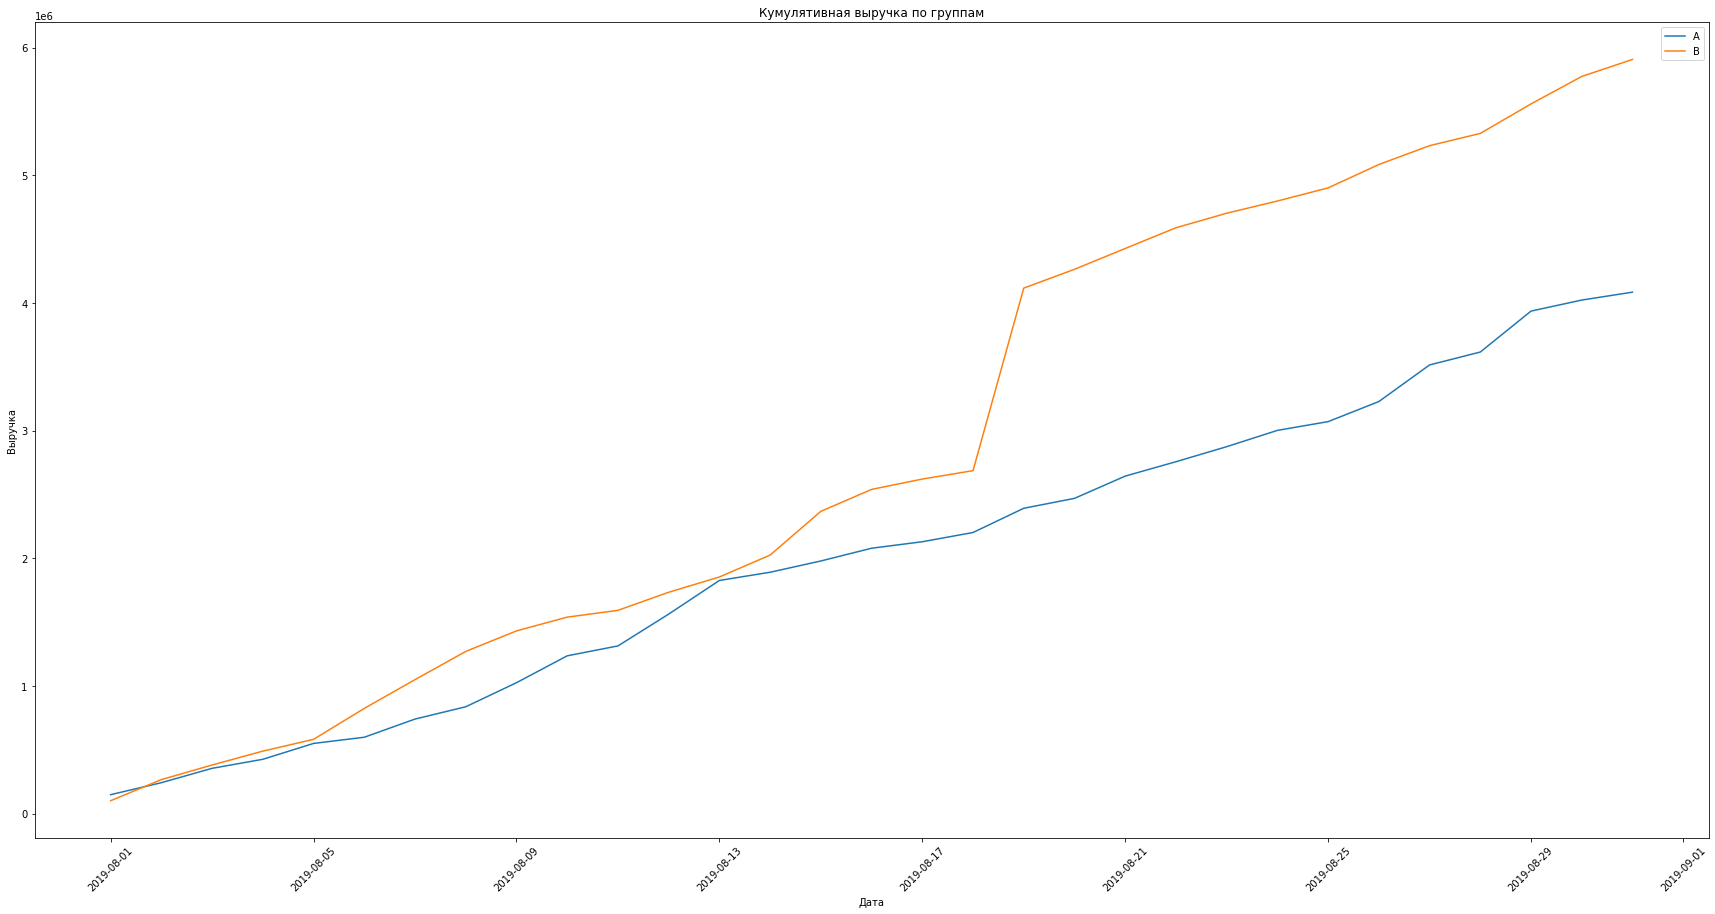

In [27]:
import matplotlib.pyplot as plt

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

#plt.xticks(rotation=45)
plt.figure(figsize=(30,15))
plt.xticks(rotation=45)

# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.title('Кумулятивная выручка по группам')
plt.xlabel('Дата')
plt.ylabel('Выручка')
## задаем масштаб осей
#plt.axis(["2019-08-09", '2019-08-23', '100000', '6000000'])
plt.legend()
plt.show()


### Вывод:
До 17 января выручка стабильно росла у групп обоих тестов. После 17 января, можно увидеть, что выручка с заказов в группе B заметно выросла и дальше продолжила стабильно расти.

<a id='6'></a>
**Постройте график кумулятивного среднего чека по группам. Сделайте выводы и предположения**

[*Назад к оглавлению*](#Оглавление)

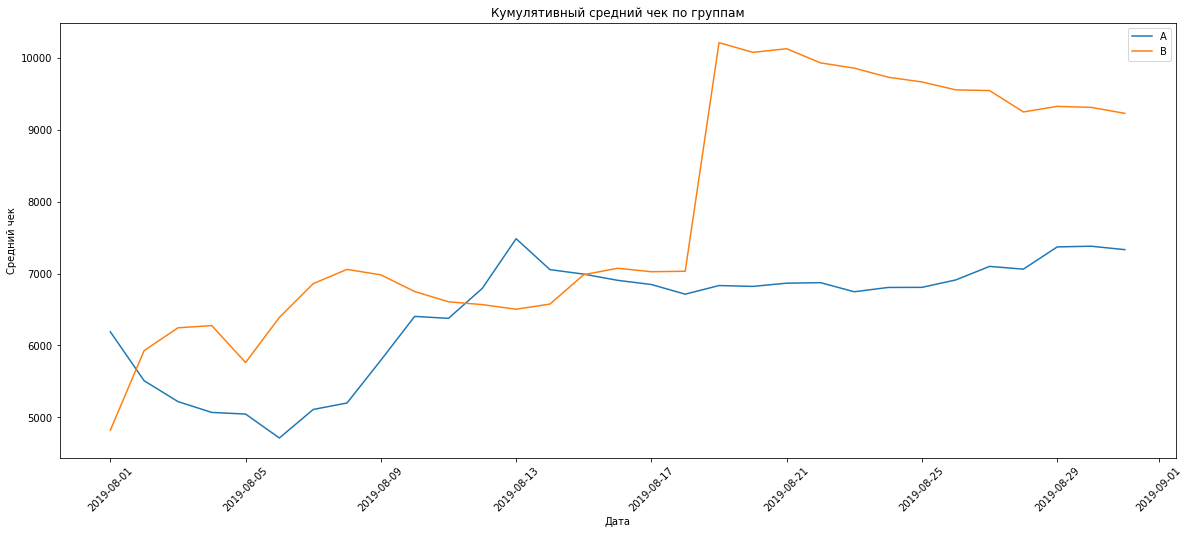

In [28]:
plt.figure(figsize=(20,8))
plt.xticks(rotation=45)
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.title('Кумулятивный средний чек по группам')
plt.xlabel('Дата')
plt.ylabel('Средний чек')
plt.legend() 

### Вывод:
Средний чек из группы B после 17 января вырос почти в два раза. Возможно есть какие-то аномальные суммы заказов.

<a id='7'></a>
**Постройте график относительного изменения кумулятивного среднего чека группы B к группе A. Сделайте выводы и предположения.**

[*Назад к оглавлению*](#Оглавление)

In [29]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']
# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

In [30]:
cumulativeDataA.sample()

,date,group,orders,buyers,revenue,visitors,conversion
20,2019-08-11,A,206,187,1313683,6980,0.029513


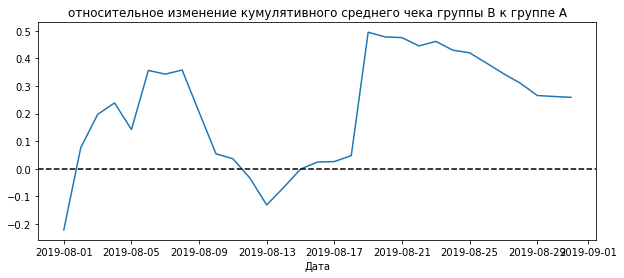

In [31]:
mergedCummulativeData = cumulativeDataA.merge(cumulativeDataB, left_on='date', right_on='date', suffixes=['A', 'B'])
mergedCummulativeData.head(5)
plt.figure(figsize=(10,4))
plt.plot(mergedCummulativeData['date'], ((mergedCummulativeData['revenueB']/mergedCummulativeData['ordersB'])/
                                       (mergedCummulativeData['revenueA']/mergedCummulativeData['ordersA'])-1))
plt.axhline(y=0, color='black', linestyle = '--')
plt.title('относительное изменение кумулятивного среднего чека группы B к группе A')
plt.xlabel('Дата')
plt.show()

### Вывод:
Сильные колебания среднего чека группы B к группе A могут говорить о том, что есть какие-то аномальные заказы в группе B.

<a id='8'></a>
**Постройте график кумулятивной конверсии по группам. Сделайте выводы и предположения**

[*Назад к оглавлению*](#Оглавление)

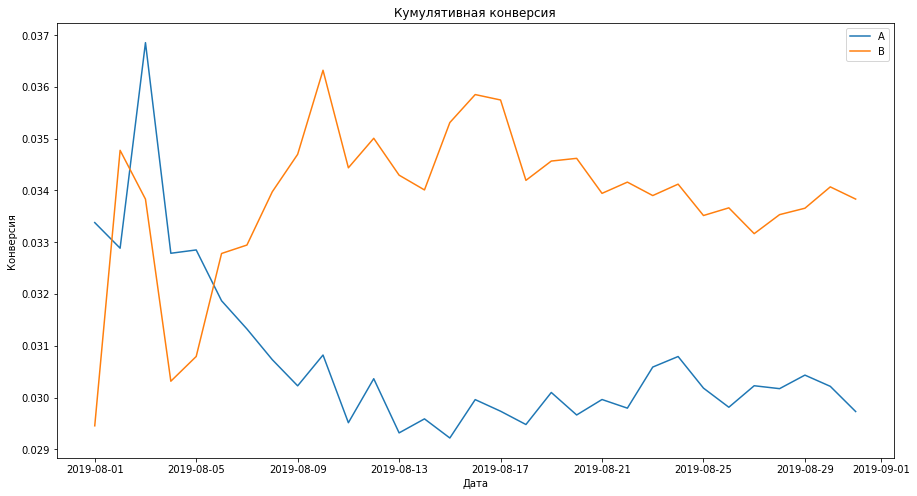

In [32]:
mergedCummulativeData['conversionA'] =  mergedCummulativeData['ordersA'] / mergedCummulativeData['visitorsA'] 
mergedCummulativeData['conversionB'] =  mergedCummulativeData['ordersB'] / mergedCummulativeData['visitorsB']
mergedCummulativeData.head(5)
plt.figure(figsize=(15,8))
plt.plot(mergedCummulativeData['date'], mergedCummulativeData['conversionA'], label='A')
plt.plot(mergedCummulativeData['date'], mergedCummulativeData['conversionB'], label='B')
plt.title('Кумулятивная конверсия')
plt.xlabel('Дата')
plt.ylabel('Конверсия')
plt.legend()
plt.show()

### Вывод:
Конверсия группы B заметно выше конверсии группы A. После всплеска конверсий групп, конверсия группы A пошла на спад, а группы B на рост

<a id='9'></a>
**Постройте график относительного изменения кумулятивной конверсии группы B к группе A. Сделайте выводы и предположения.**

[*Назад к оглавлению*](#Оглавление)

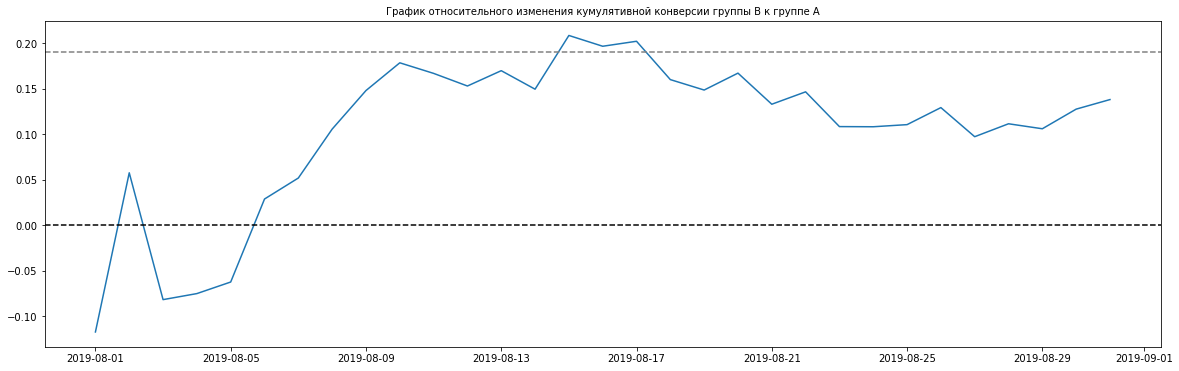

In [33]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(20,6))
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительное изменение конверсии группы B к группе A");
plt.title('График относительного изменения кумулятивной конверсии группы B к группе A', size=10)
plt.axhline(y=0, color='black', linestyle='--');
plt.axhline(y=0.19, color='grey', linestyle='--');

### Вывод:
На протяжении всего теста кроме самого начала группа B лидирует по конверсии

<a id='12'></a>
**Постройте точечный график количества заказов по пользователям. 
Сделайте выводы и предположения**

[*Назад к оглавлению*](#Оглавление)

In [34]:
ordersByUsers = orders.groupby('userId').agg({'orderId':'nunique'}).reset_index()

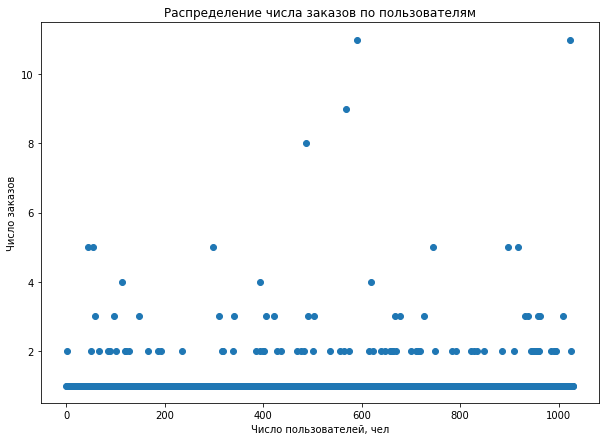

In [35]:
plt.figure(figsize=(10, 7))
x_values = pd.Series(range(0,len(ordersByUsers)))
plt.scatter(x_values, ordersByUsers['orderId'])
plt.title('Распределение числа заказов по пользователям')
plt.xlabel('Число пользователей, чел')
plt.ylabel('Число заказов')
plt.show()

### Вывод:
Есть не мало пользователей которые делали заказы больше 2 раз

<a id='13'></a>
**Посчитайте 95-й и 99-й перцентили количества заказов на пользователя. Выберите границу для определения аномальных пользователей.**

[*Назад к оглавлению*](#Оглавление)

In [36]:
display(np.percentile(ordersByUsers['orderId'], [95, 99])) 

array([2., 4.])

### Вывод:
не более 5% пользователей делали больше 2 заказов. Примем пользователей, которые совершали больше 2 заказов как аномальных.

<a id='14'></a>
**Постройте точечный график стоимостей заказов. Сделайте выводы и предположения.**

[*Назад к оглавлению*](#Оглавление)

Text(0, 0.5, 'Стоимость заказов')

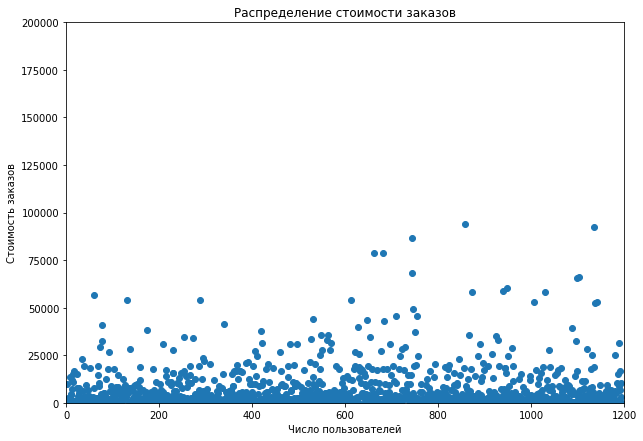

In [37]:
plt.figure(figsize=(10, 7))
x_values = pd.Series(range(0,len(orders)))
plt.axis([0, 1200, 0, 200000])
plt.scatter(x_values, orders['revenue'])
plt.title('Распределение стоимости заказов')
plt.xlabel('Число пользователей')
plt.ylabel('Стоимость заказов')

### Вывод: 
большинство заказов не выше 30 000 рублей

<a id='15'></a>
**Посчитайте 95-й и 99-й перцентили стоимости заказов. Выберите границу для определения аномальных заказов.**

[*Назад к оглавлению*](#Оглавление)

In [38]:
display(np.percentile(orders['revenue'], [95, 99])) 

array([28000. , 58233.2])

In [39]:
display(np.percentile(orders_drop['revenue'], [95, 99])) 
orders_drop

array([26785., 53904.])

,orderId,userId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B
...,...,...,...,...,...
1191,3592955527,608641596,2019-08-14,16490,B
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A


### Вывод:
Не больше чем у 5% заказов стоимость выше 28000. Примем за аномальные заказы выше 28000

<a id='16'></a>
**Посчитайте статистическую значимость различий в конверсии между группами по «сырым» данным. Сделайте выводы и предположения.**

[*Назад к оглавлению*](#Оглавление)

Сформулируем гипотезы

Н0 - различий в конверсиях между группами по «сырым» данным нет

Н1 - различий в конверсиях между группами по «сырым» данным есть

In [40]:
ordersByUsersA = orders[orders['group']=='A'].groupby('userId', as_index=False).agg({'orderId':'nunique'})
ordersByUsersA.columns = ['userId', 'orders']
ordersByUsersB = orders[orders['group']=='B'].groupby('userId', as_index=False).agg({'orderId':'nunique'})
ordersByUsersB.columns = ['userId', 'orders']

In [41]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'orderId', 'userId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'orderId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'orderId', 'userId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'orderId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

#print(data.head(5)) 

In [42]:
sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

In [43]:
alpha = 0.05
results = stats.mannwhitneyu(sampleA, sampleB)
print('P-value: {0:.4f}'.format(results.pvalue))
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

P-value: 0.0168
Отвергаем нулевую гипотезу


### Вывод:
Различия в конверсиях в группах по «сырым» данным есть

<a id='17'></a>
**Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Сделайте выводы и предположения**

[*Назад к оглавлению*](#Оглавление)

Сформулируем гипотезы

Н0 - различия в среднем чеке заказа между группами по «сырым» данным статистически не значимы

Н1 - различия в среднем чеке заказа между группами по «сырым» данным статистически значимы

In [44]:
revenue_A = orders[orders['group']=='A']['revenue']
#revenue_A

In [45]:
revenue_B = orders[orders['group']=='B']['revenue']
#revenue_B

In [46]:
results = stats.mannwhitneyu(revenue_A, revenue_B)
print('P-value: {0:.3f}'.format(results.pvalue))
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

P-value: 0.729
Не получилось отвергнуть нулевую гипотезу


### Вывод:
Различия в среднем чеке заказа между группами по «сырым» данным статистически не значимы

<a id='18'></a>
**Посчитайте статистическую значимость различий в конверсии между группами по «очищенным» данным. Сделайте выводы и предположения.**

[*Назад к оглавлению*](#Оглавление)

Сделаем срезы пользователей с числом заказов 3 и более — usersWithManyOrders и пользователей, совершивших заказы дороже 28000 — usersWithExpensiveOrders.

In [47]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 2]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > 2]['userId'],
    ],
    axis=0,
)

In [48]:
usersWithExpensiveOrders = orders[orders['revenue'] > 28000]['userId']

In [49]:
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)

In [50]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

In [51]:
sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 

Сформулируем гипотезы

Н0 - различия в конверсии между группами по «очищенным» данным статистически не значимы

Н1 - различия в конверсии между группами по «очищенным» данным статистически значимы

In [52]:
results = stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)
print('P-value: {}'.format(results.pvalue))
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

P-value: 0.013042592743036745
Отвергаем нулевую гипотезу


### Вывод:
Различия в конверсии между группами по «очищенным» данным статистически значимы

<a id='19'></a>
**Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделайте выводы и предположения.**

[*Назад к оглавлению*](#Оглавление)

In [53]:
#зададим предельные кол-во заказов и сумму покупки для формирования списка аномальных пользователей
limit_orders = 3
limit_revenue = 28000

In [54]:
usersWithManyOrders = pd.concat([ordersByUsersA[ordersByUsersA['orders']>limit_orders]['orders'], 
                                ordersByUsersB[ordersByUsersB['orders']>limit_orders]['orders']], axis = 0)

In [55]:
usersWithExpensiveOrders = orders[orders['revenue']>limit_revenue]['orderId']

In [56]:
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
abnormalUsers.head(5)

18             4
227            5
340            6
499            7
858    192721366
dtype: int64

In [57]:
#отфильтруем аномальных пользователей
sampleAFiltered_revenue = orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['userId'].isin(abnormalUsers)),
                )
            ]['revenue']

sampleBFiltered_revenue = orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['userId'].isin(abnormalUsers)),
                )
            ]['revenue'] 

In [58]:
result = (stats.mannwhitneyu(
    sampleAFiltered_revenue, 
    sampleBFiltered_revenue)[1]).round(5)

In [59]:
result

0.72929

Сформулируем гипотезы

Н0 - различия в среднем чеке заказа между группами по «очищенным» данным статистически не значимы

Н1 - различия в среднем чеке заказа между группами по «очищенным» данным статистически значимы

In [60]:
alpha = .05

if (result < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Не получилось отвергнуть нулевую гипотезу


### Вывод:
Различия в среднем чеке заказа между группами по «очищенным» данным статистически не значимы

<a id='20'></a>
**Примите решение по результатам теста и объясните его. Варианты решений:** 
1. Остановить тест, зафиксировать победу одной из групп. 
2. Остановить тест, зафиксировать отсутствие различий между группами. 
3. Продолжить тест.

[*Назад к оглавлению*](#Оглавление)

*Решение - остановить тест и зафиксировать победу группы B*

несмотря на то, что по среднему чеку статистической значимости не обнаружено, рекомендуется остановить тест и зафиксировать победу группы B. Потому что конверсия группы B была выше на протяжении почти всего эксперимента. Также мы убедились, что конверсия между группами до и после очистки от аномальных значений является статистически значимой.